# Change Detection - Ratio Method Notebook
Detects change at a location over time by analysing the ratio between Sentinel RGB bands from images of the same location at different times. Calibrated on pre-post disaster imagery and EMS damage data for Hurricane Maria's passage through Dominica in 2017.

In [1]:
# Define location, dates and satellite
location = 'roseau'
lat, lon = 15.3050, -61.3787
zoom = 15
st_date, end_date = ['2017-08-15', '2017-10-01'], ['2017-09-15', '2017-11-01']
satellite = "sentinel-2:L1C"

# Define log ratio properties
band = "blue"
threshold =  0.001
kSize = 1 # Dilatation kernel size

# Damage grades to be compared for accuracy
dmgAssess = "/home/jovyan/DominicaDamageAssessment/EMS/EMSR246_04ROSEAU_02GRADING_v1_5500_settlements_point_grading.dbf" # Damage assessment database location
grades = ['Completely Destroyed','Highly Damaged'] # 'Not Applicable','Negligible to slight damage', 'Moderately Damaged', 'Highly Damaged'
area = 0.0005 # GeoJson properties for building damages, building area in lat/long degrees
dmgFile = 'geojsons/'+location+'Damage'+str(area)[2:]+'g'+str(len(grades))+'.geojson' # Damage file name qualifying location and area size
landPoly = 'coastlines/swDominicaCoastline.geojson'

In [2]:
# Import packages
import IPython
import ipywidgets
import ipyleaflet
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import random
import os
import tensorflow as tf
from change_utils import FullArray, DrawControl
from utils import make_ground_dataset_from_polygons, get_center_location
from unet import UNet
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, Point
import geojson

import descarteslabs as dl
import descarteslabs.workflows as wf
from descarteslabs.vectors import FeatureCollection, properties as p
from descarteslabs.workflows import GeoContext

## 1 - Visualise the images
Before and after images for selected band. You'll need to click the magic marker to scaler the colours properly.

In [3]:
m1 = wf.interactive.MapApp()
m1.center = (lat, lon)
m1.zoom = zoom

for i in range(len(st_date)):
    img = wf.ImageCollection.from_id(satellite,start_datetime=st_date[i], end_datetime=end_date[i]).pick_bands("red green blue cloud-mask red-edge-2 red-edge-3 red-edge-4 nir swir1 swir2")
    img = img.filter(lambda img: img.properties["cloud_fraction"] <= 0.06)
    img_msk = img.map(lambda img: img.mask(img.pick_bands('cloud-mask')==1)) # if bandNum > 1 else img
    mos = (img_msk.mosaic().pick_bands(band))
    globals()['mos_'+str(i+1)] = mos
    mos.visualize('Image '+str(i+1), map=m1)

m1


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


## 2 - Change Detection
Get ratio of before/after images and create a mask from a threshold.

In [4]:
# Take the log of the ratio of both composites (equivalent to difference of logs)
log_ratio = wf.log10(mos_1 / mos_2)
change = (log_ratio > threshold)

In [5]:
# Define simple functions for erosion and dilation
def erode_op(map_layer, iters, kernel):
    map_layer = ~map_layer
    for i in range(iters):
        map_layer = wf.conv2d(map_layer, kernel) > 0
    map_layer = ~map_layer 
    return map_layer

def dilate_op(map_layer, iters, kernel):
    for i in range(iters):
        map_layer = map_layer * 1.0
        map_layer = wf.conv2d(map_layer, kernel) > 0
    return map_layer

# Define a kernel and perform one erosion followed by two dilations
kernel = wf.Kernel(dims=(kSize,kSize), data=np.ones([1,kSize**2]).tolist()[0])
#     dims=(3,3), data=[0.,1.,0.,
#                         1.,1.,1.,
#                         0.,1.,0.,])

eroded = erode_op(change, iters=1, kernel=kernel)
dilated = dilate_op(eroded, iters=2, kernel=kernel)

In [6]:
# Change detection map
m2 = wf.map.map
m2.center = (lat, lon)
m2.zoom = zoom
 
mos_1.visualize('Before', map=m2)
mos_2.visualize('After', map=m2)
log_ratio.visualize('Ratio', map=m2)
lyr = dilated.mask(dilated==0).visualize('Detected Change', checkerboard=False, colormap='bwr') # Visualize the resulting mask
lyr.opacity = 0.7
ipywidgets.HBox([wf.map])

`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jup…

## 3 - Filter results and plot against known damages

In [7]:
# Convert mask into coordinate array
# Get vector of pixels which have changed coordinates
mask = dilated.mask(dilated==0)
gtx = wf.map.geocontext()
change = mask.compute(geoctx=gtx)

# Get latitude & longitude of each pixel in mask (whether true or false)
bounds = change.geocontext['bounds']
lats, longs = np.linspace(bounds[3],bounds[1],change.geocontext['arr_shape'][0]), np.linspace(bounds[0],bounds[2],change.geocontext['arr_shape'][1])

# Create matrix of coordinates for pixels with change detected
xm, ym = np.meshgrid(longs,lats)
xc, yc = xm*(1-change.ndarray.mask[0]), ym*(1-change.ndarray.mask[0])


Job ID: 52ae9ee2a73f5836bc7b830ab5538370fb42de3cc368d3eb
[######] | Steps: 80/80 | Stage: SUCCEEDED                                    

In [8]:
# Get geodataframe for pixel points with filter for ocean
df = pd.DataFrame(columns=['Latitude', 'Longitude'])
land = gpd.read_file(landPoly)
for i,j in zip(np.nonzero(xc)[0], np.nonzero(xc)[1]):
    if Point([xc[i][j],yc[i][j]]).within(land.geometry[0]):
        df = df.append({'Latitude': yc[i][j],'Longitude': xc[i][j]}, ignore_index=True)
    
det = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

In [9]:
# Load in damage geojson from ground data
settlements = gpd.read_file(dmgAssess).to_crs({'init': 'epsg:4326'})
color_dict = {'Not Applicable':'green','Negligible to slight damage':'blue', 'Moderately Damaged':'yellow', 'Highly Damaged':'orange', 'Completely Destroyed':'red'}

# Filter settlements to be within specified damage grade and location polygon
damage = settlements[settlements.grading.isin(grades)]
damage = damage[damage.within(Polygon(change.geocontext['geometry']['coordinates'][0]))]

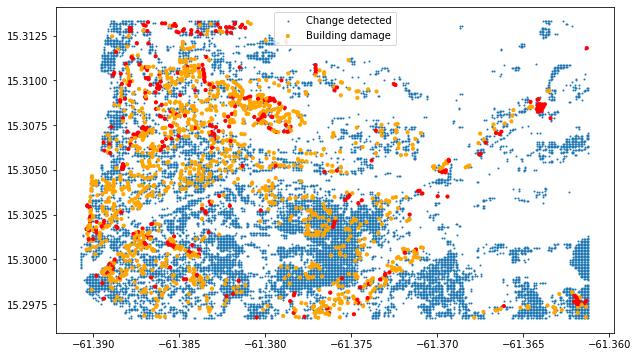

In [10]:
# Plot detected vs damaged
plt.figure(figsize=(10,6))
plt.scatter(det.geometry.x,det.geometry.y,s=1, label='Change detected')
plt.scatter(damage.geometry.x,damage.geometry.y,color=[color_dict[i] for i in damage.grading],s=10,label='Building damage')
plt.legend()

## 4 - Quantify Accuracy of ratio vs damage assessments

In [40]:
# Get damage into Geojson with area surrounding centroid
if not os.path.exists(dmgFile):
    features = []
    for i in damage.index:
        poly = Polygon([[damage.geometry.x[i], damage.geometry.y[i]], [damage.geometry.x[i]+area, damage.geometry.y[i]], [damage.geometry.x[i]+area, damage.geometry.y[i]+area], [damage.geometry.x[i], damage.geometry.y[i]+area], [damage.geometry.x[i], damage.geometry.y[i]]])
        features.append(geojson.Feature(properties={"Damage": damage.grading[i]}, geometry=poly))

    fc = geojson.FeatureCollection(features)
    with open(dmgFile, 'w') as f:
        geojson.dump(fc, f)

In [41]:
# Determine accuracy from telling if there is a change pixel included in each damage area polygon
dmg = gpd.read_file(dmgFile)

print('Damaged buildings: ',len(dmg))
acc = np.zeros([len(dmg),1])
for j in dmg.index:
    for i in det.index:
        if det.geometry[i].within(dmg.geometry[j]):
            acc[j,0] = True
            print(i,j)
            break

print('Accuracy:', sum(acc)/len(acc))

Damaged buildings:  1603
11566 0
11418 1
12677 2
12308 3
12199 4
12396 5
11568 6
12316 7
12686 8
12962 9
12318 10
11422 11
12490 12
12586 13
12089 14
11969 15
11841 16
11713 17
11422 18
11968 19
12089 20
12092 21
11847 22
12209 23
11568 24
12473 25
12473 26
13112 27
12836 28
12473 29
12757 30
12386 31
12387 32
12299 33
12385 34
4514 35
4285 36
4285 37
4285 38
4619 39
4511 40
5408 44
5408 45
4907 46
5784 47
5408 49
4819 50
8119 54
8348 55
8119 56
8348 57
8115 58
8114 63
8114 64
8114 65
9043 66
8808 67
9553 68
8807 69
9552 70
9165 71
9043 72
8808 73
8348 74
8119 75
8119 76
8115 77
9043 81
9552 82
9552 83
10162 84
9706 85
9043 86
12908 87
12454 90
12154 91
12153 92
12153 93
12153 94
13188 95
12549 96
11790 97
12549 98
12152 99
12152 100
12811 101
12905 102
12905 103
12545 104
12150 105
12454 106
12813 108
12812 109
12359 111
12261 112
12453 113
12905 114
12356 115
12258 116
12258 117
12905 118
9689 121
11661 122
11364 123
12153 124
11200 125
10631 127
10314 128
11064 129
11515 130
10906 1

In [42]:
# Calculate recall
print('Pixels: ',len(det))
rec = np.zeros([len(det),1])
for j in det.index:
    for i in dmg.index:
        if det.geometry[j].within(dmg.geometry[i]):
            rec[j,0] = True
            print(i,j)
            break
            
print('Recall:', sum(rec)/len(rec))

Pixels:  13540
1325 9
1324 10
1324 11
1324 12
1330 16
1367 17
1367 18
1358 19
1358 20
1358 21
1356 22
1356 23
1356 24
1356 25
1355 28
1355 29
1355 30
1355 31
1346 32
1344 33
1343 34
1343 35
1341 36
1322 53
1322 54
1329 56
1332 57
1358 58
1358 59
1358 60
1357 61
1357 62
1357 63
1357 64
1357 65
1353 66
1353 67
1353 68
1353 69
1353 70
1352 71
1346 72
1338 73
1339 74
1322 89
1322 90
1322 91
1358 93
1358 94
1358 95
1357 96
1357 97
1357 98
1357 99
1357 100
1357 101
1353 102
1353 103
1353 104
1353 105
1353 106
1352 107
1352 108
1343 109
1339 110
1322 121
1322 122
1358 126
1358 127
1361 128
1360 129
1360 130
1360 131
1360 132
1354 133
1353 134
1353 135
1353 136
1353 137
1353 138
1352 139
1338 140
1321 144
1321 145
1321 146
1321 147
1321 148
1321 149
1326 151
1322 152
1358 156
1358 157
1361 158
1360 159
1360 160
1360 161
1360 162
1354 163
1348 164
1343 165
1343 166
1343 167
1321 174
1321 175
1321 176
1321 177
1321 178
1326 182
1322 183
1322 184
1333 186
1360 187
1360 188
1360 189
1360 190
1350 

In [43]:
# F1 Score
a = sum(acc)/len(acc)
r = sum(rec)/len(rec)
f1 = 2*(a*r)/(a+r)
print('Accuracy:',a[0],'\nRecall:',r[0],'\nF1 score:',f1[0])

Accuracy: 0.8951965065502183 
Recall: 0.4446824224519941 
F1 score: 0.5942001810562932


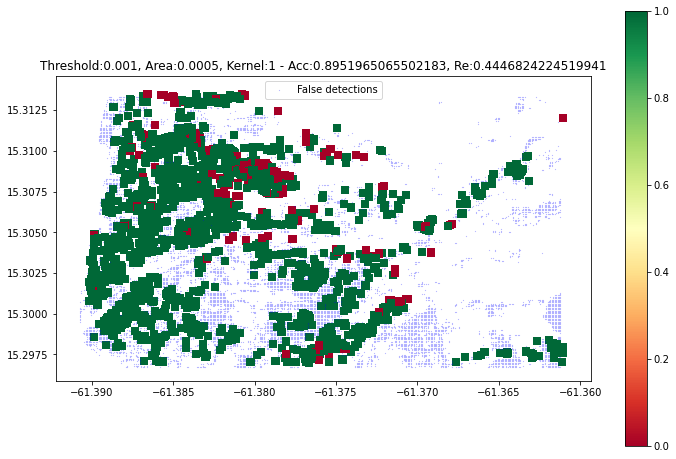

In [44]:
# Plot success of change detection
# Accurate points
def points(gdb,filt):
    x = np.array(gdb.geometry.x)*(1-filt).transpose()
    y = np.array(gdb.geometry.y)*(1-filt).transpose()
    return x[x != 0], y[y != 0]

dmg['found'] = pd.Series(acc[:,0], index=dmg.index)
plt = dmg.plot(figsize=(12,8), column='found',legend=True,cmap='RdYlGn')#,scheme="quantiles"

x1, y1 = points(det,rec)
plt.scatter(x1,y1,s=0.01,color='b', label='False detections')
plt.set_title('Threshold:'+str(threshold)+', Area:'+str(area)+', Kernel:'+str(kSize)+' - Acc:'+str((sum(acc)/len(acc))[0])+', Re:'+str((sum(rec)/len(rec))[0]))
plt.legend()
plt.figure.savefig('results/'+location+'_t'+str(threshold)[2:]+'a'+str(area)[2:]+'g'+str(len(grades))+'.png')

# --------------- END ------------------------